In [1]:
# Prophet model for Cherry Blossom Bloom Day
# This notebook trains a Prophet model (with regressors) on the cherry blossom dataset
# using the same split logic as the other notebooks: train/val within 1921-2015 (80/20) and test 2016-2025.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# try to import Prophet; give a clear error if missing
try:
    prophet_mod = importlib.import_module('prophet')
    Prophet = getattr(prophet_mod, 'Prophet')
except Exception:
    try:
        # older installs named fbprophet
        fbprophet = importlib.import_module('fbprophet')
        Prophet = getattr(fbprophet, 'Prophet')
    except Exception:
        raise ImportError("This cell requires the 'prophet' package (or 'fbprophet'). Install with: pip install prophet")

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# 1) Load data
DATA_PATH = '../data/cherry_blossom_data.csv'
df = pd.read_csv(DATA_PATH)
print('Rows loaded:', len(df))
# Ensure numeric columns
numeric_cols = ['days_dec_ge_45','days_jan_ge_45','days_feb_ge_45','prec_winter',
                'mean_temp_winter','surface_temp_chg','climate_incidents']
for c in numeric_cols + ['bloom_day','year']:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# drop rows with missing essential values
df = df.dropna(subset=['year','bloom_day']).reset_index(drop=True)

# create a date column for Prophet: use Jan 1st of each year
df['ds'] = pd.to_datetime(df['year'].astype(int).astype(str) + '-01-01')
df = df.sort_values('year').reset_index(drop=True)
# single time series
# if there are duplicate years, keep the first occurrence
df = df.drop_duplicates(subset=['year'], keep='first').reset_index(drop=True)


Rows loaded: 105


In [4]:
# 2) Splits: train/val within 1921-2015 (80/20), test 2016-2025
train_val = df[(df['year'] >= 1921) & (df['year'] <= 2015)].sort_values('year').reset_index(drop=True)
test_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)].sort_values('year').reset_index(drop=True)

if len(train_val) == 0:
    raise ValueError('No data in 1921-2015 to train/validate on')

n = len(train_val)
train_n = int(np.floor(n * 0.8))
train_df = train_val.iloc[:train_n].reset_index(drop=True)
val_df = train_val.iloc[train_n:].reset_index(drop=True)

print(f'Train rows: {len(train_df)}, Val rows: {len(val_df)}, Test rows: {len(test_df)}')


Train rows: 76, Val rows: 19, Test rows: 10


In [5]:
# 3) Prepare dataframes for Prophet (ds, y) and add regressors
FEATURES = numeric_cols
TARGET = 'bloom_day'

prophet_train = train_df[['ds', 'bloom_day'] + FEATURES].rename(columns={'bloom_day':'y'})
prophet_val = val_df[['ds', 'bloom_day'] + FEATURES].rename(columns={'bloom_day':'y'})
prophet_test = test_df[['ds', 'bloom_day'] + FEATURES].rename(columns={'bloom_day':'y'})

# Prophet requires no NA in regressors; fill or forward-fill small gaps
for f in FEATURES:
    prophet_train[f] = prophet_train[f].fillna(method='ffill').fillna(method='bfill').fillna(0.0)
    prophet_val[f] = prophet_val[f].fillna(method='ffill').fillna(method='bfill').fillna(0.0)
    prophet_test[f] = prophet_test[f].fillna(method='ffill').fillna(method='bfill').fillna(0.0)


In [6]:
# 4) Fit Prophet with regressors
m = Prophet()
for r in FEATURES:
    m.add_regressor(r)

print('Fitting Prophet (this is fast for a single series)...')
m.fit(prophet_train)


Fitting Prophet (this is fast for a single series)...


20:39:26 - cmdstanpy - INFO - Chain [1] start processing
20:39:26 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# 5) Predict on validation and test sets
# For Prophet, prediction requires a dataframe with ds and regressors present
val_pred_df = prophet_val[['ds'] + FEATURES].copy()
val_forecast = m.predict(val_pred_df)
# extract point forecast
val_pred = val_forecast['yhat'].values

test_pred_df = prophet_test[['ds'] + FEATURES].copy()
test_forecast = m.predict(test_pred_df)
# predicted values and intervals
if 'yhat' in test_forecast:
    test_pred = test_forecast['yhat'].values
else:
    # fallback if API differs
    test_pred = test_forecast.iloc[:, 0].values


In [8]:
# 6) Metrics on validation and test sets
val_y = prophet_val['y'].values
val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
val_mae = mean_absolute_error(val_y, val_pred)
val_wmape = np.sum(np.abs(val_y - val_pred)) / np.sum(np.abs(val_y))

print('Validation RMSE: {:.3f}, MAE: {:.3f}, WMAPE: {:.3%}'.format(val_rmse, val_mae, val_wmape))

# ensure y_test exists even if test set empty (helps static analysis)
if len(test_df) > 0:
    y_test = prophet_test['y'].values
else:
    y_test = np.array([])

if len(test_df) > 0:
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    test_mae = mean_absolute_error(y_test, test_pred)
    test_wmape = np.sum(np.abs(y_test - test_pred)) / np.sum(np.abs(y_test))

    print('\nTest set performance (2016-2025)')
    print('Rows:', len(test_df))
    print('RMSE: {:.3f}'.format(test_rmse))
    print('MAE: {:.3f}'.format(test_mae))
    print('WMAPE: {:.3%}'.format(test_wmape))


Validation RMSE: 8.003, MAE: 6.315, WMAPE: 6.948%

Test set performance (2016-2025)
Rows: 10
RMSE: 6.986
MAE: 5.661
WMAPE: 6.676%


In [9]:
# 7) Save test forecasts to CSV
if len(test_df) > 0:
    out = test_df[['year']].copy()
    out['actual'] = y_test
    out['forecast'] = test_pred
    # include intervals if available
    if 'yhat_lower' in test_forecast and 'yhat_upper' in test_forecast:
        out['lower'] = test_forecast['yhat_lower'].values
        out['upper'] = test_forecast['yhat_upper'].values
    out_path = os.path.join('notebooks', 'prophet_test_forecasts.csv')
    os.makedirs('notebooks', exist_ok=True)
    out.to_csv(out_path, index=False)
    print('Saved test forecasts to', out_path)


Saved test forecasts to notebooks/prophet_test_forecasts.csv


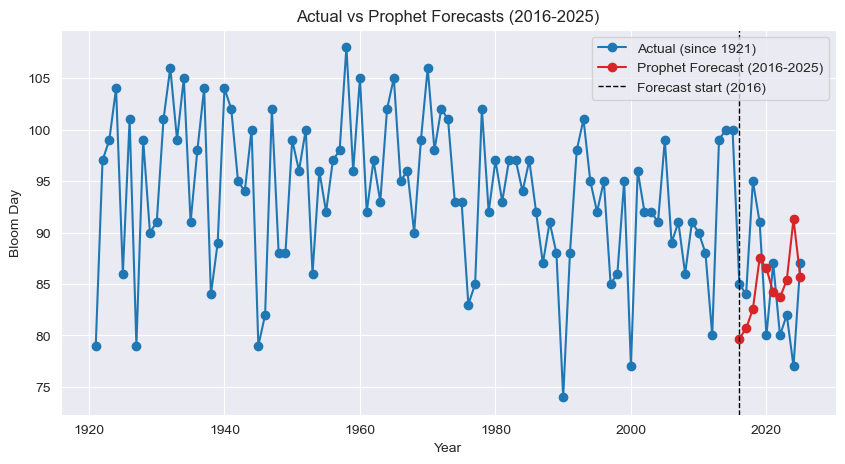

In [10]:
# 8) Plot actuals since 1921 and forecasts from 2016 onward
plt.figure(figsize=(10,5))
# full actuals
plt.plot(df['year'], df['bloom_day'].values, marker='o', color='tab:blue', label='Actual (since 1921)')
if len(test_df) > 0:
    plt.plot(test_df['year'], test_pred, marker='o', color='tab:red', label='Prophet Forecast (2016-2025)')
    plt.axvline(2016, color='k', linestyle='--', linewidth=1, label='Forecast start (2016)')

plt.xlabel('Year')
plt.ylabel('Bloom Day')
plt.title('Actual vs Prophet Forecasts (2016-2025)')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# End of Prophet notebook
